<a href="https://colab.research.google.com/github/EGR557-SPR21-Team4/EGR557-SPR21-Team4.github.io/blob/main/System_Dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dynamics I


The Dynamics model below represents one of three sarrus mechanisms from our system. The red frame represents the Newtonian frame and the black frames represent the frame joints. Figure 3a shows all of the points and vectors needed to create our system. All of the vectors are relative to the Newtonian frame shown in red.

![](https://drive.google.com/uc?export=view&id=1WGMy-oskfulGSYSXEImoDG69Q70OPvkV)

<h0><center>**Figure 1a: Sarrus Mechanism Dynamics Model**</center></h0>

| Rigid Body | Mass (kilograms) | Legth (meters) |
| --- | --- | --- |
| A | 0.0004 | 0.0508 |
| B | 0.0002 | 0.0254 |
| C | 0.0002 | 0.0254 |
| D | 0.0004 | 0.0508 |
| E | 0.0002 | 0.0254 |
| F | 0.0002 | 0.0254 |

<h0><center>**Table 1a**: Dynamics Model Lengths and Masses</center></h0>

Show plots inline and ensures that pynamics is installed.

In [1]:
%matplotlib inline

In [2]:
!pip install pypoly2tri idealab_tools foldable_robotics pynamics

Import all required packages.

In [3]:
#This block of code imports the necessary modules created by Daniel M. Aukes
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic 
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle
import pynamics.integration
import sympy
import numpy
import matplotlib.pyplot as plt
plt.ion()
from math import pi
from pynamics.constraint import Constraint 
import scipy.optimize

Create a pynamics system where the mechanism is located.

In [4]:
#This block of code create a new system object and set that system as the global system within the module so that other variables can use and find it
system = System()
pynamics.set_system(__name__,system)

1. Scale: Ensure your system is using SI units. You should be specifying lengths in meters (so millimeters should be scaled down to the .001 range), forces in Newtons, and radians (not degrees), and masses in kg. You may make educated guesses about mass for now.

Declare all constants using SI units.

In [5]:
#This block of code declares and store constants
l0 = Constant(0.0508,'l0',system) #defines the lengths (in meters) of each frame (1:1 ratio of paper model)
l1 = Constant(0.0254,'l1',system) #1in ~ 0.0254m
l2 = Constant(0.0254,'l2',system)
l3 = Constant(0.0508,'l3',system)
l4 = Constant(0.0254,'l4',system)
l5 = Constant(0.0254,'l5',system)

mA = Constant(0.04,'mA',system) #defines the mass (in kg) of each frame 
mB = Constant(0.002,'mB',system) #1g ~ 0.001kg
mC = Constant(0.002,'mC',system)
mD = Constant(0.04,'mD',system)
mE = Constant(0.002,'mE',system)
mF = Constant(0.002,'mF',system)

g = Constant(9.81,'g',system) #defines gravity (in m/s^2)
b = Constant(0,'b',system)  #defines damping coefficient (in kg/s^2)
k = Constant(0,'k',system)  #defines spring coefficient (kg/s^2)

preload0 = Constant(0*pi/180,'preload0',system) #defines the spring preload to establish neutral point of frame (radians)
preload1 = Constant(0*pi/180,'preload1',system)
preload2 = Constant(0*pi/180,'preload2',system)
preload3 = Constant(0*pi/180,'preload3',system) 
preload4 = Constant(0*pi/180,'preload4',system)
preload5 = Constant(0*pi/180,'preload5',system)
preload6 = Constant(0*pi/180,'preload6',system)

Ixx_A = Constant(2,'Ixx_A',system) #defines the inertia (kg*m^2) of each frame 
Iyy_A = Constant(2,'Iyy_A',system)
Izz_A = Constant(2,'Izz_A',system)
Ixx_B = Constant(1,'Ixx_B',system)
Iyy_B = Constant(1,'Iyy_B',system)
Izz_B = Constant(1,'Izz_B',system)
Ixx_C = Constant(1,'Ixx_C',system)
Iyy_C = Constant(1,'Iyy_C',system)
Izz_C = Constant(1,'Izz_C',system)
Ixx_D = Constant(2,'Ixx_D',system)  
Iyy_D = Constant(2,'Iyy_D',system)
Izz_D = Constant(2,'Izz_D',system)
Ixx_E = Constant(1,'Ixx_E',system)
Iyy_E = Constant(1,'Iyy_E',system)
Izz_E = Constant(1,'Izz_E',system)
Ixx_F = Constant(1,'Ixx_F',system)
Iyy_F = Constant(1,'Iyy_F',system)
Izz_F = Constant(1,'Izz_F',system)

In [6]:
#This block of code specifies the precision of the integration 
tol = 1e-12

In [7]:
#This block of code defines variables for time that can be used throughout the script
tinitial = 0
tfinal = 17
fps = 30
tstep = 2/fps
t = numpy.r_[tinitial:tfinal:tstep]

Create the differentiable state variables, cooresponding to the joint angles.

In [8]:
#This block of code creates dynamic state variables for the angles shown in our kinematics model
q0,q0_d,q0_dd = Differentiable('q0',system) #angle between N and A frames
q1,q1_d,q1_dd = Differentiable('q1',system) #angle between A and B frames
q2,q2_d,q2_dd = Differentiable('q2',system) #angle between B and C frames
q3,q3_d,q3_dd = Differentiable('q3',system) #angle between C and D frames
q4,q4_d,q4_dd = Differentiable('q4',system) #angle between D and E frames
q5,q5_d,q5_dd = Differentiable('q5',system) #angle between E and F frames

Initial guess for starting positions.

In [9]:
#This block of code sets the initial guess for the mechanisms starting position (in radians) and velocity (in m/s)
initialvalues = {}
initialvalues[q0] = 0*pi/180  #optimal angle is 0
initialvalues[q0_d] = 0*pi/180
initialvalues[q1] = 45*pi/180  #optimal angle is 45
initialvalues[q1_d] = 0*pi/180
initialvalues[q2] = 90*pi/180  #optimal angle is 90
initialvalues[q2_d] = 0*pi/180
initialvalues[q3] = 45*pi/180   #optimal angle is 45
initialvalues[q3_d] = 0*pi/180
initialvalues[q4] = 45*pi/180   #optimal angle is 45
initialvalues[q4_d] = 0*pi/180
initialvalues[q5] = 90*pi/180   #optimal angle is 90
initialvalues[q5_d] = 0*pi/180

Retrieve state variables in the order they are stored in the system.

In [10]:
#This block of code orders the initial values in a list in such a way that the integrator can use it in the same order that it expects the variables to be supplied
statevariables = system.get_state_variables()
ini = [initialvalues[item] for item in statevariables]

Create the main reference frames, with one cooresponding to each rigid link.

In [11]:
#This block of code initializes frames
N = Frame('N')
A = Frame('A')
B = Frame('B')
C = Frame('C')
D = Frame('D')
E = Frame('E')
F = Frame('F')

Declare N as the Newtonian (fixed) frame.

In [12]:
#This block of code sets N frame as the newtonian frame (see kinematic diagram from above)
system.set_newtonian(N) 

Rotate frames about their z-axes so they align with the correct rigid link.

In [13]:
#This block of code shows frame rotation in the Z direction
A.rotate_fixed_axis_directed(N,[0,0,1],q0,system)  #the A frame rotates about the N frame in the Z direction (0,0,1) by q0 degrees
B.rotate_fixed_axis_directed(A,[0,0,1],q1,system)  #the B frame rotates about the A frame in the Z direction (0,0,1) by q1 degrees
C.rotate_fixed_axis_directed(B,[0,0,1],q2,system)  #the C frame rotates about the B frame in the Z direction (0,0,1) by q2 degrees
D.rotate_fixed_axis_directed(C,[0,0,1],q3,system)  #the D frame rotates about the C frame in the Z direction (0,0,1) by q3 degrees
E.rotate_fixed_axis_directed(D,[0,0,1],q4,system)  #the E frame rotates about the D frame in the Z direction (0,0,1) by q4 degrees
F.rotate_fixed_axis_directed(E,[0,0,1],q5,system)  #the F frame rotates about the E frame in the Z direction (0,0,1) by q5 degrees

Define vectors for each of the joint locations. 

In [14]:
#This block of code defines the points needed to create the mechanism 
pNA = 0*N.x + 0*N.y    #pNA (point NA) position is 0 units in the direction of N reference frame's x direction (0*N.x) and y direction (0*N.y)
pAB = pNA + l0*A.x     #pAB position is pNA's position plus l0 units in the direction of ref frame A's x direction 
pBC = pAB + l1*B.x     #pBC position is pAB's position plus l1 units in the direction of ref frame B's x direction
pCD = pBC + l2*C.x     #pCD position is pBC's position plus l2 units in the direction of ref frame C's x direction
pDE = pCD + l3*D.x     #pDE position is pCD's position plus l3 units in the direction of ref frame D's x direction
pEF = pDE + l4*E.x     #pEF position is pDE's position plus l4 units in the direction of ref frame E's x direction
pFtip = pEF + l5*F.x   #pFtip position is pEF's position plus l5 units in the direction of ref frame F's x direction

Compute center of mass for each of the frame locations. 

In [15]:
#This block of code defines the centers of mass of each link (halfway along the length of each frame)
pAcm=pNA+l0/2*A.x  #pA (link A) position is pNA's position plus one half of l0 units in the direction of ref frame A's x direction
pBcm=pAB+l1/2*B.x  #pB (link B) position is pAB's position plus one half of l1 units in the direction of ref frame B's x direction
pCcm=pBC+l2/2*C.x  #pC (link C) position is pBC's position plus one half of l2 units in the direction of ref frame C's x direction
pDcm=pCD+l3/2*D.x  #pD (link D) position is pCD's position plus one half of l3 units in the direction of ref frame D's x direction
pEcm=pDE+l4/2*E.x  #pE (link E) position is pDE's position plus one half of l4 units in the direction of ref frame E's x direction
pFcm=pEF+l5/2*F.x  #pF (link F) position is pEF's position plus one half of l5 units in the direction of ref frame F's x direction

Compute angular velocity for each of the joint locations. 

In [16]:
#This block of code computes and returns the angular velocity between frames
wNA = N.getw_(A)
wAB = A.getw_(B)
wBC = B.getw_(C)
wCD = C.getw_(D)
wDE = D.getw_(E)
wEF = E.getw_(F)

2. Define Inertias: Add a center of mass and a particle or rigid body to each rotational frame. You may use particles for now if you are not sure of the inertial properties of your bodies, but you should plan on finding these values soon for any “payloads” or parts of your system that carry extra loads (other than the weight of paper).

Compute the inertia dynamics of each body and defines a rigid body on each frame.

In [17]:
#This block of code compute the inertia dynamics of each body and defines a rigid body on each frame
IA = Dyadic.build(A,Ixx_A,Iyy_A,Izz_A)
IB = Dyadic.build(B,Ixx_B,Iyy_B,Izz_B)
IC = Dyadic.build(C,Ixx_C,Iyy_C,Izz_C)
ID = Dyadic.build(D,Ixx_D,Iyy_D,Izz_D)
IE = Dyadic.build(E,Ixx_E,Iyy_E,Izz_E)
IF = Dyadic.build(F,Ixx_F,Iyy_F,Izz_F)

BodyA = Body('BodyA',A,pAcm,mA,IA,system)
BodyB = Body('BodyB',B,pBcm,mB,IB,system)
BodyC = Body('BodyC',C,pCcm,mC,IC,system)
BodyD = Body('BodyD',D,pDcm,mD,ID,system)
BodyE = Body('BodyE',E,pEcm,mE,IE,system)
BodyF = Body('BodyF',F,pFcm,mF,IF,system)

3. Add Forces: Add the acceleration due to gravity. Add rotational springs in the joints (using k=0 is ok for now) and a damper to at least one rotational joint. You do not need to add external motor/spring forces but you should start planning to collect that data.

Adding the forces: note that in this section damping and stiffness are 0, so only the input torque and gravity cause changes to the system dynamics.

In [18]:
#This block of code adds forces and torques to the system with the generic "addforce" method.
#The first parameter supplied is a vector describing the force applied at a point or the torque applied along a given rotational axis. 
#The second parameter is the vector describing the linear speed (for an applied force) or the angular velocity(for an applied torque)
system.addforce(-b*wNA,wNA)
system.addforce(-b*wAB,wAB)
system.addforce(-b*wBC,wBC)
system.addforce(-b*wCD,wCD)
system.addforce(-b*wDE,wDE)
system.addforce(-b*wEF,wEF)

In [19]:
#This block of code adds spring forces
#The first value is the linear spring constant
#The second value is the “stretch” vector, indicating the amount of deflection from the neutral point of the spring.
#The final parameter is the linear or angluar velocity vector (depending on whether your spring is a linear or torsional spring)
system.add_spring_force1(k,(q0-preload1)*N.z,wNA)
system.add_spring_force1(k,(q1-preload2)*A.z,wAB)
system.add_spring_force1(k,(q2-preload3)*B.z,wBC)
system.add_spring_force1(k,(q3-preload4)*C.z,wCD)
system.add_spring_force1(k,(q4-preload5)*E.z,wDE)
system.add_spring_force1(k,(q5-preload6)*F.z,wEF)

(<pynamics.force.Force at 0x7f83830282d0>,
 <pynamics.spring.Spring at 0x7f8383028210>)

In [20]:
#This block of code globally applies the force of gravity to all particles and bodies
system.addforcegravity(-g*N.y)

4. Constraints: Keep mechanism constraints in, but follow the pendulum example of double-differentiating all constraint equations.
If you defined your mechanism as unattached to the Newtonian frame, add enough constraints so that it is fully attached to ground (for now). you will be eventually removing these constraints.

Create all the vector equation constraints.

In [21]:
#This block of code defines the closed loop kinematics (vectors) of the sarrus mechanism.
#Constraint 1:
eq_vector=pFtip-pNA
#Constraint 2:
eq_vector2= pDE-pCD
#Constraint 3:
eq_vector3= pEF-pBC
#Constraint 4:
eq_vector4= pDE-pNA

Convert the vector constraints into scalar equations that can be solved.

In [22]:
#This block of code defines the systems constraints based on the vectors listed above
eq = []

#pFtip and pNA have to be on the same point
eq.append((eq_vector).dot(N.x))
eq.append((eq_vector).dot(N.y))

#pDE and pCD must have the same y coordinate in the N frame
eq.append((eq_vector2).dot(N.y))
#pEF and pBC must have the same y coordinate in the N frame
eq.append((eq_vector3).dot(N.y))

#pDE and pNA must have the same x coordinate in the N frame
eq.append((eq_vector4).dot(N.x))


eq_d=[(system.derivative(item)) for item in eq]
eq_dd=[(system.derivative(item)) for item in eq_d]

Identify independent and dependent variables.

In [23]:
#This block of code defines the dependent and independent values
qi = [q1]
qd = [q0,q2,q3,q4,q5] #number of items in qd should equal the number of constraints above

For dependent variables, create an initial guess and create a copy of symbolic constants dictionary and add the initial value of qi to it.

In [24]:
#This block of code recalls and stores link lengths or constants declared earlier
constants = system.constant_values.copy() 
defined = dict([(item,initialvalues[item]) for item in qi])
constants.update(defined)

Substitute constants in equation.

In [25]:
eq = [item.subs(constants) for item in eq]
print(eq)

[0.0254*((-sin(q3)*sin(q4) + cos(q3)*cos(q4))*sin(q5) + (sin(q3)*cos(q4) + sin(q4)*cos(q3))*cos(q5))*((-0.707106781186548*sin(q0) - 0.707106781186547*cos(q0))*cos(q2) - (-0.707106781186547*sin(q0) + 0.707106781186548*cos(q0))*sin(q2)) + 0.0254*((-sin(q3)*sin(q4) + cos(q3)*cos(q4))*cos(q5) + (-sin(q3)*cos(q4) - sin(q4)*cos(q3))*sin(q5))*((-0.707106781186548*sin(q0) - 0.707106781186547*cos(q0))*sin(q2) + (-0.707106781186547*sin(q0) + 0.707106781186548*cos(q0))*cos(q2)) + 0.0254*((-0.707106781186548*sin(q0) - 0.707106781186547*cos(q0))*sin(q2) + (-0.707106781186547*sin(q0) + 0.707106781186548*cos(q0))*cos(q2))*(-sin(q3)*sin(q4) + cos(q3)*cos(q4)) + 0.0254*((-0.707106781186548*sin(q0) - 0.707106781186547*cos(q0))*cos(q2) - (-0.707106781186547*sin(q0) + 0.707106781186548*cos(q0))*sin(q2))*(sin(q3)*cos(q4) + sin(q4)*cos(q3)) + 0.0508*(-sin(q2)*sin(q3) + cos(q2)*cos(q3))*(-0.707106781186547*sin(q0) + 0.707106781186548*cos(q0)) + 0.0508*(sin(q2)*cos(q3) + sin(q3)*cos(q2))*(-0.707106781186548*s

Convert to numpy array and sum the error.

In [26]:
#This block of code converts to numpy array and sums the error
error = (numpy.array(eq)**2).sum()

Convert to a function that scipy can use. Sympy has a “labmdify” function that evaluates an expression, but scipy needs a slightly different format.

In [27]:
#This block of code converts to a function that scipy can use 
#Sympy has a "labmdify" function that evaluates an expression
#Scipy uses a different format
f = sympy.lambdify(qd,error)

def function(args):
    return f(*args)

Take the derivative of the equations to linearize with regard to the velocity variables.

In [28]:
#This block of code solves for the desired mechanism (orange) givin the initial guesses (blue)
#An incorrect initial guess was used on purpose to visualize that the system was solved correctly
guess = [initialvalues[item] for item in qd]
result = scipy.optimize.minimize(function,guess)

if result.fun>1e-3:
    raise(Exception("out of tolerance"))
print("Tolerance:", result.fun)

ini = []
for item in system.get_state_variables():
    if item in qd:
        ini.append(result.x[qd.index(item)])
    else:
        ini.append(initialvalues[item])

Tolerance: 7.559382801190848e-33


5. Solution: Add the code from the bottom of the pendulum example for solving for f=ma, integrating, plotting, and animating. Run the code to see your results. It should look similar to the pendulum example with constraints added, as in like a rag-doll or floppy.

In [29]:
#This block of code calculates the symbolic expression for F and ma
f,ma = system.getdynamics()

2021-03-31 09:01:35,335 - pynamics.system - INFO - getting dynamic equations


In [30]:
#This block of code solves the system of equations F=ma plus any constraint equations that have been added above. 
#It returns one or two variables. 
#func1 is the function that computes the velocity and acceleration given a certain state.
#lambda1(optional) supplies the function that computes the constraint forces as a function of the resulting states
#The below function inverts the mass matrix numerically every time step.
func1,lambda1 = system.state_space_post_invert(f,ma,eq_dd,return_lambda = True)

2021-03-31 09:01:37,460 - pynamics.system - INFO - solving a = f/m and creating function
2021-03-31 09:01:37,502 - pynamics.system - INFO - substituting constrained in Ma-f.
2021-03-31 09:01:52,447 - pynamics.system - INFO - done solving a = f/m and creating function
2021-03-31 09:01:52,449 - pynamics.system - INFO - calculating function for lambdas


In [31]:
#This block of code integrates the function calculated above
states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))

2021-03-31 09:01:52,477 - pynamics.integration - INFO - beginning integration
2021-03-31 09:01:52,480 - pynamics.system - INFO - integration at time 0000.00
2021-03-31 09:01:54,986 - pynamics.integration - INFO - finished integration


Create a figure that shows how the state variables evolve over the time of the simulation. In other words, plot how are the links rotating over time.

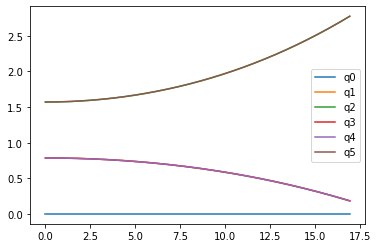

In [32]:
#This block of code calculates and plots a variety of data from the previous simulation
plt.figure()
artists = plt.plot(t,states[:,:6])
plt.legend(artists,['q0','q1','q2', 'q3', 'q4', 'q5'])

Prepare an animation of the mechanism's motion and show some of the frames.

2021-03-31 09:01:55,409 - pynamics.output - INFO - calculating outputs
2021-03-31 09:01:55,479 - pynamics.output - INFO - done calculating outputs


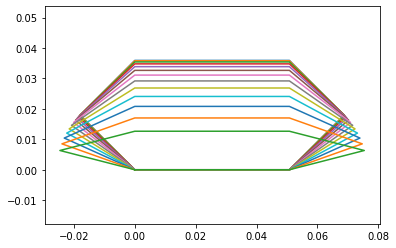

In [33]:
#This block of code calculates and plots the motion of the system
points = [pNA,pAB,pBC,pCD,pDE,pEF,pNA]
points_output = PointsOutput(points,system)
y = points_output.calc(states)
points_output.plot_time(20)

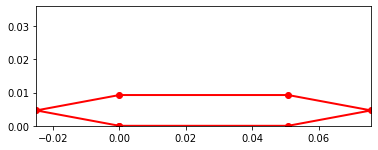

In [34]:
#This block of code produces a figure of the animations end position using matplotlib
points_output.animate(fps = fps,movie_name = 'render.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')

Plot an animation of the mechanism.

In [35]:
#This block of code animates the figure above
from matplotlib import animation, rc
from IPython.display import HTML
HTML(points_output.anim.to_html5_video())

6. **Tuning:** Now adjust the damper value  to something nonzero, that over 10s shows that the system is settling.

The system behaves like a rag-doll when we set the damper constant to 0. In the video shown above, the system does not behave in such manner because we have set the damper constant to a value greater than 0 in order to satisfy part 6. 

## Dynamics Plan

**Material Selection**

Our team has decided to use cardstock and cardboard for the main materials of fabrication. Each team member will either use cardboard or cardstock to test the dynamics of our system. In addition to these materials, one of the team members has access to a 3D printer. We will use PLA and a 3D printer to create professional parts for our prototype. Additionally, our team is using pen springs, three micro servo motors, a microcontroller, and glue.
 


**Parameters Modeled**

Because our team has three members, we decided to split one parameter simulation per member. Andrei will work on actuator fitting, Feba will gather damping information, and Charlotte will collect material link and joint stiffness information. The tests executed for each of these parameter models will be explained below:

**Actuator Fitting:** because the team is using a spring and motor to contract and expand the sarrus mechanisms,  the team must first calculate the force/torque needed to contract the spring. This will be done with theoretical calculations through MATLAB code and physical testing with the use of a scale and ruler to determine force vs displacement. Once the torque required to contract the spring is calculated, a motor will be specced based on its max torque capabilities. 

**Joint Stiffness Calculations:** the team will execute a variety of different cantilever tests using both cardboard and cardstock to determine the superior material of the two. Each material will be clamped to a desk and weights will slowly be attached to the end of the material. The team will gather deflection information and calculate the overall stiffness of the materials using equations and data from the cantilever tests. 

**Damping Calculations:** to determine the damping of the sarrus mechanisms, video software was used to track the motion of the mechanism when a weight is dropped onto it. The video software will output an oscillating signal which will then be used to determine the damping coefficient of the sarrus mechanism.

**Prototyping**

Because Andrei has a 3D printer, cardstock, cardboard, springs, glue, motors, and microcontrollers, he will be in charge of creating our team's prototype. The team's mechanical design will consist of three sarrus mechanisms placed on top of one another vertically. The sarrus mechanisms are made from cardstock material and the spring/support system is made from PLA printed parts. 

**Individual Deliverables**

**Andrei:** actuator fitting, updating code, prototyping, compiling information to a report (Jupyter notebook and google doc will be used for this).

**Feba:** damping calculations, adding model fitting routines.

**Charlotte:** material stiffness calculations and testing, filtering input data

## Dynamics Preparation

**Overview**

The main objective of this "Dynamic II" code is to re-consolidate everything learned from testing our system and implement it back into our teams dynamic model. In the previous "Dynamic I" code our team was able to model our mechanism with no constraints, essentially collasing on itself, similar to a puppet when the strings are cut. In this updated dynamics code, our system will simulate real world characteristics such as: forces, torques, friction, gravity, stiffness, damping, enviroment (walls/floor), etc. We will still be simulating one sarrus mechanisms for now, but we plan to add the other two sarrus links in the next iteration of this code. This code will show a sarrus link with a compression spring in the center pushing the sarrus mechanism open. A motor will contract and relase the spring with the use of a sinusoidal input. This will simulate the sarrus mechansim expanding (making contact with the walls) and contracting (removing conact with the walls). Frictional forces are added and will eventually allow our system to translate up vertical spaces (when we implement all three sarrus mechanisms into the code).

**Proposed Mechanism**

The team's mechanical design consists of three sarrus mechanisms placed on top of one another vertically as shown in Figure 1a. The sarrus mechanisms are made from cardstock material and the spring/support system is made from PLA printed parts. When stationary, the compression springs will force the sarrus mechanisms to hold an expanded position as shown in Figure 1b. On the other hand, when the servo motors are activated, the spring is compressed and the sarrus mechanisms translate in the negative y-direction and expand in the positive and negative x-directions as shown in Figure 1c. This will allow for the mechanism to anchor to nearby walls similar to the way a razor clam anchors to nearby sand with its “foot”. For testing purposes, the team used their hand force to pull on a string in place of a servo motor and pulley. The team chose three sarrus links in order to allow the mechanism to translate vertically in the following manner: 

All sarrus mechanisms will begin motion in an extended position, with the spring mechanism forcing the sarrus link open. 
The top-most sarrus mechanism will use a servo motor to contract the spring and expand its links in both the positive and negative x-direction. This will lock the mechanism into place with the surrounding walls as shown in Figure 1d. 
The middle sarrus mechanism will then contract its spring in order to pull the bottom-most link upwards.
The bottom-most sarrus mechanism will then contract its spring in order to lock itself against the surrounding walls. 
The middle and top-most sarrus mechanisms will then expand their springs in order to unlock from the surrounding walls and move upwards.
Then the mechanism recycles the process starting with step two. This will allow for the system to translate in an upward or positive y-direction.

In order to achieve this motion, each sarrus mechanism is controlled by a separate motor to allow for individual control of each link. Eventually, an electrical housing box will screw into the bottom plate of the spring mechanism seen in Figure 2a. This housing will hold the servo motor and pulley. 

![](https://drive.google.com/uc?export=view&id=14OyVayXmyKn6sY9pSST3aA40gDJfQarl)

<h0><center>**Figure 1a: Three Sarrus Mechanism CAD Model**</center></h0>

![](https://drive.google.com/uc?export=view&id=1q6m-grWiyhsKr27Q5DR6yTFuP8tuE1RD)

<h0><center>**Figure 1b: Sarrus Mechanism at Rest**</center></h0>

![](https://drive.google.com/uc?export=view&id=1cBw-21Qx46WWRSQkZwsjYupufQRomJ9x)

<h0><center>**Figure 1c: Sarrus Mechanism Contracted**</center></h0>

![](https://drive.google.com/uc?export=view&id=1-WRjsQzo2S2X6_ZZbG98iIefpl5bhzpg)

<h0><center>**Figure 1d: Sarrus Mechanism Anchored to Walls**</center></h0>

**Forces and Torques**

A compression spring mechanism created with CAD is used to force each of the three sarrus links in an extended initial position Figure 2a. When decompressed, the spring mechanism has a height of 0.05715 meters and 0.03810 meters when compressed. As a result, the compression spring mechanism shown in Figure 2a is **limited to a maximum vertical displacement of 0.01905 meters**. With the use of MATLAB and physical testing from prior assignments, the team found the **spring constant to be approximately 200.4500 newtons per meter**.   

![](https://drive.google.com/uc?export=view&id=1uJuygAjuQitrqtTZ0hjUYvIRA_TbuWlu)

<h0><center>**Figure 2a: CAD Rendering of Assembled Printed Parts**</center></h0>

A servo motor with a 3D-printed pully spool and thread is used to contract each of the three sarrus links. With a spring constant of approximately 200.4500 newtons per meter and a max displacement of 0.01905 meters, we get a resultant force of 3.8186 Newtons using Hooke’s Law. We know that load torque is equal to force (F) multiplied by the distance (r) between the center of rotation and the force point. Assuming the team prints a three dimensional pulley with a radius of 0.00635 meters, the **maximum torque required by the motor is 0.0242 Newton-meters**.

Our team is neglecting the spring and motor forces for the following calculations. From the free body diagram shown in Figure 3b we determined that the sum of the forces in the vertical direction must be zero at equilibrium. This means that 2*us-mg=0. In the horizontal direction, the two normal forces must add up to zero. From the free body diagram we see that 2*us*Fnormal=mg, therefore, Fnormal=mg/(2*us). This gives an expression for how hard the wall pushes on the sarrus mechanism in the perpendicular sense. However, the sarrus mechanisms outer joints must push with the opposite of the net force exerted on it. Lets assume the sarrus mechanism pushes against each wall with a force called Fpush. Therefore, each of the two sarrus joints must push with a magnitude of **Fpush=(mg/2)*sqrt(1+(1/us^2))**. 

![](https://drive.google.com/uc?export=view&id=19T0KG6qzQCcRG7sI2BtEbwAZz6k8SxJL)

<h0><center>**Figure 3b: 2D Free Body Diagram of System**</center></h0>

# Calculating Youngs Modulus by Carrying out Cantilever Tests**

The current plan for our model is to use cardstock as the primary material. Since this is out primary material, cantilever tests were run on cardstock samples to determine obtain the stiffness of the material. 

**Materials:**

1. Clamp
2. Four 125mm x 25mm samples of cardstock
3. At least 5 weights of varying masses
4. Callipers
5. String
6. Tape

**Note:** The procedure below was provided by Dr. Daniel Aukes

**Procedure:**

1. Prepare the samples for testing

>Four near-identicle pieces of cardstock measuring 25mm x 125mm were measured as seen in Figure 4a. One of these samples will not be loaded and will be referred to as the base. Once they were cut to length, they were measured and marked 25mm from each end as future reference points. The samples were labeled to keep measurement data consistent and properly organized.  

<h0><center>![](https://drive.google.com/uc?export=view&id=1ynLG-WXk-SBirYwUKMUHDujojH2nz4J-)</center></h0>

<h0><center>**Figure 4a:** Three 125mm x 25mm Cardstock Samples Used for the Cantilever Testing</center></h0>

2. Measure the thickness of each sample in two places.

>The thicknesses of each of the samples was suprisingly the same in all locations. While there was a point where it looked like one of the thicknesses was to be 0.01 mm thinner, it ultimately settled on the same value of 0.23 mm (0.00023m) as the rest of the samples. These thicknesses were marked on the samples themselves as can be found in Figure 4a, as well as below in Figure 4b. Once all of the measurements were completed, strings were added to each of the samples so that masses could later be attached from the loop on the end. 

<h0><center>![](https://drive.google.com/uc?export=view&id=1Nzotby39dipaw0AVKfaJJ7RLwBgPK-B-)</center></h0>

<h0><center>**Figure 4b:** Measurements of the Samples</center></h0>

3. Determine the masses that will be used in the experiments.

> For the cantilever experiments, it is required that one has at least five different masses that can be used to test the deflection of the sample. Initially, the masses ranged from 3 - 14g. When it was apparent that the 3g weight was pushing the edge of the mass limit, as the deflection was very high, the masses were scaled down considerably, with hte highest being 2.32g, as can be seen in Figure 4c.

<h0><center>![](https://drive.google.com/uc?export=view&id=1rDd9WOV62gx1sjLtI2I8zB6QPh-_KXLA)</center></h0>

<h0><center>**Figure 4c: Six Masses Used in the Cantilever Testing**</center></h0>

4. Clamp two samples together on a flat surface, the top layer being the base.

>The base being clamped atop the sample allows for consistent, stable measurements where the sample is not pulled or twisted positionally when loaded. The setup for the tests is seen in Figure 4d. From here, the distance between the sample and the base was measured to get an initial defelction based on imperfections in the sample and base. 

<h0><center>![](https://drive.google.com/uc?export=view&id=1kyl2vwCS7DPF50r-UdSgjUPjCgvd-foV)</center></h0>

<h0><center>**Figure 4d:** Setup for the Cantilever Test (No Load)</center></h0>

5. Set up the camera.

>The camera was positioned on top of a stack of books directly in front of the sample to ensure all photos were taken from the same distance and position.

6. Measure the deflection of the sample from the base when sample is under a load.

>Each of the six loads were attached to the sample beam, from which the deflection was measured. Once each mass was attached to the sample, a picture was taken, as seen in Figure 4e, and the displacement was measured and recorded. All six masses were applied to each of the three samples, and the data is recorded as seen in Figure 4f. These values remove the initial distance between the base and each sample. A graphical representation of the mass in relation to the deflection can be found in Figure 4g.

<h0><center>![](https://drive.google.com/uc?export=view&id=1Z8fim4IP56-LZHtWyX8cLgP1WSTfVUj4)</center></h0>

<h0><center>**Figure 4e:** Image of a Test Run with a Load</center></h0>

<h0><center>![](https://drive.google.com/uc?export=view&id=1KARcWBZd8jpwEy8nbhqYidVZz7ZON7ib)</center></h0>

<h0><center>**Figure 4f:** Deflection Measurements (No load)</center></h0>


<h0><center>![](https://drive.google.com/uc?export=view&id=1Z53lOnZMieCo5OBBttMm6JpKD2CNrUYk)</center></h0>

<h0><center>**Figure 4g:** Graphical Representation of the Deflection Versus Mass Graph</center></h0>


7. Calculate the Youngs Modulus value (E).

>Once the deflection of the samples under each load has been measured, it can be seen that all but one of the variables in the beam equations found in Figure 4h have been found. These can be rearranged as in Figure 4i to find Youngs Modulus (E), using the equation in Figure 4j to find I. Calculating hte Youngs modulus, the values of which can be found in Figure 4k, results in the overall stiffness of the material.

<h0><center>![](https://drive.google.com/uc?export=view&id=13sYUqlWbKJajg9H_eO65xmBHBB41wxFT)</center></h0>

<h0><center>**Figure 4h:** Equations Provided by Dr. Daniel Aukes for Calculating Deflection</center></h0>

<h0><center>![](https://drive.google.com/uc?export=view&id=1S2Un6kaIXa04tkesGwCa2v5waSoU5-8Q)</center></h0>

<h0><center>**Figure 4i:** Rearranged Equation used to find Youngs Modulus (E)</center></h0>

<h0><center>![](https://drive.google.com/uc?export=view&id=1Z1Ufu6ChbVo5PKFlBfmJfIZv--RuBnY3)</center></h0>

<h0><center>**Figure 4j:** Variable I</center></h0>

<h0><center>![](https://drive.google.com/uc?export=view&id=1zg9uVHGLA5EyhDm92tJqAw0sQPz2LznU)</center></h0>

<h0><center>**Figure 4k:** The Youngs Modulus (E) Values Calculated</center></h0>


# Approximating Compliant Beams

**Note:** The code below was provided by Dr. Daniel Aukes

The code below uses the beam deflection equations found in Figures 4h-4j to initally find the cross sectional moment of intertia. From there, the code allows for the determination of the value of x that results in an accurate determination of the deflection and angle of a beam with a single joint. 

In [36]:
#The following code is heavily based on that created by Dr. Daniel Aukes
import sympy
q = sympy.Symbol('q')
d = sympy.Symbol('d')
L = sympy.Symbol('L')
P = sympy.Symbol('P')
h = sympy.Symbol('h')
b = sympy.Symbol('b')
E = sympy.Symbol('E')
x = sympy.Symbol('x')

subs = {}
#subs[k]=1000
subs[P]=.00016
subs[L]=.1
subs[b]=.025
subs[h]=.1
subs[E]=7.0818
subs[x]=.5

In [37]:
I = b*h**3/12
d1 = P*L**3/3/E/I
d1.subs(subs)

0.00361490016662431

In [38]:
q1 = P*L**2/2/E/I
q1.subs(subs)

0.0542235024993646

In [39]:
k1 = P*L*(1-x)/(sympy.asin(P*L**2/(3*E*I*(1-x))))
k1.subs(subs)

0.000110556584514503

In [40]:
d2 = L*(1-x)*sympy.sin(P*L*(1-x)/k1)
d2.subs(subs)

0.00361490016662431

In [41]:
q2 = P*L*(1-x)/k1
q2.subs(subs)

0.0723611355680998

In [42]:
k2 = 2*E*I*(1-x)/(L)
q3 = P*L*(1-x)/k2
q3.subs(subs)

0.0542235024993646

In [43]:
d3 = L*(1-x)*sympy.sin(P*L*(1-x)/k2)
d1.subs(subs)

0.00361490016662431

In [44]:
d3.subs(subs)

0.00270984675940322

In [45]:
del subs[x]
error = []
error.append(d1-d2)
error.append(q1-q2)
error= sympy.Matrix(error)
error = error.subs(subs)
error

⎡                     0                      ⎤
⎢                                            ⎥
⎢                         ⎛0.036149001666243⎞⎥
⎢0.0542235024993646 - asin⎜─────────────────⎟⎥
⎣                         ⎝      1 - x      ⎠⎦

In [46]:
import scipy.optimize
f = sympy.lambdify((x),error)

def f2(args):
    a = f(*args)
    b = (a**2).sum()
    return b

sol = scipy.optimize.minimize(f2,[.25])
sol



      fun: 3.9928096992175975e-11
 hess_inv: array([[72.33682164]])
      jac: array([-1.02805959e-06])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([0.33292887])

In [47]:
subs[x]=sol.x[0]
d2.subs(subs)
q2.subs(subs)

0.0542171836310331

# Calculate Damping Coefficient using Motion Capure

The aim of the experiment is to track motion of the joint at pBC (shown in figure  above) using the software called 'Tracker' and to collect data from it's motion. The plot of time vs Y-axis is observed and analyzed. The data is then used in a python program to generate plots and calculate the damping coefficient.


**Experiment Setup**


**Objective:**

To create a 3D model of the sarrus link and capture its motion on video.

**Materials Used:**

1. Cardstock
2. Scissors
3. Tape
4. Glue
5. Colored Paper (orange)
6. Plain Paper
7. Smartphone with Video Capability
8. Black Marker
9. Pencil
10. Keyboard and Mouse

**Preparation:**

1. Cut the cardstock as shown in Figure 5a.
2. Cut the orange colored paper into three small squares.
3. Mark the sheet as shown in white lines in the Figure 5a.

**Procedure:**

1. Bend the sheet at the marked points.
2. Join the ends of the cutout that is 0.5inch, with tape, to complete a 3D model of the sarrus link.
3. Using the black marker, circle in one piece of colored square.
4. Glue one orange square on point pBC (shown in Figure 5b) 
5. Stick the remaining two squares below the prototype in a straight line like the points pNA and pNF, to create the base frame.
6. Attach the system to plain paper by taping them together.
7. Fix the apparatus on the table with tape. See Figure 5b.
8. Release the keyboard mouse on top of the 3D sarrus link, so as to capture the movement of the system.
9. Capture this motion by taking a video.
    
**Assumptions**

1. The base frame is fixed and rigid.
2.  The links are rigid.
3.  The joints have the same stiffness and so all results obtained at one joint applies to all others.
4.  Friction between keyboard mouse and cardstock is neglected.
5. Translation of the joint in the x axis is neglected.

**Results**

1. The captured video is run through the software, 'Tracker'. The point mass is placed at the joint pBC.
2.  The distance between the points in the base frame is measured to be 10cm.
3.  The distance measured between the lens of the camera and the experiment setup is 30cm.
4.  Since the joint was moved with an object falling on top of it, there is damping observed in the data plotted.
5. The damping is shown by the plot time vs y-axis. 
6.  The plot shown in Figure 5c is based on the x and y values obtained by the tracker.

![](https://drive.google.com/uc?export=view&id=1YH5650NvPOJbq0qpjZF2BzYd5T-lZB-7)

<h0><center>**Figure 5a:** 2D Cutout of 3D Sarrus System</center></h0>


![](https://drive.google.com/uc?export=view&id=1fnWSXjsLTL9qoZ70_ITwTXZUo0D0tD-3)

<h0><center>**Figure 5b:** The Experiment Setup</center></h0>

![](https://drive.google.com/uc?export=view&id=1iDWLbHqGEkDLPxJEz2LJItl5sr8pMGUl)

<h0><center>**Figure 5c:** Plot of Point Mass Placed at pBC.</center></h0>

**Note:** You must upload the file named "3.csv" for the code to continue running.

In [48]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import scipy.interpolate as si
from math import pi,sqrt
import math

In [49]:
from google.colab import files
uploaded = files.upload()

Saving 3.csv to 3.csv


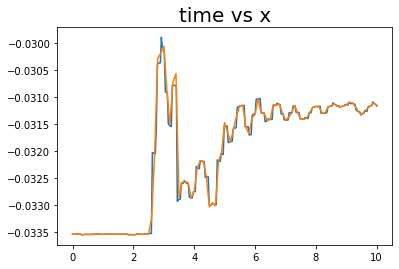

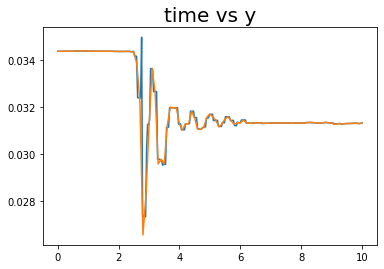

In [50]:
import io
df2 = pd.read_csv(io.BytesIO(uploaded['3.csv']))

x = df2.x.to_numpy()
y = df2.y.to_numpy()
t = df2.t.to_numpy()


xy = numpy.array([x,y]).T
f = si.interp1d(t,xy.T,fill_value='extrapolate',kind='quadratic')
new_t = numpy.r_[0:t[-1]:.1]

plt.figure()
plt.title('time vs x',fontsize = 20)
plt.plot(t,x)
plt.plot(new_t,f(new_t)[0])

plt.figure()
plt.title('time vs y',fontsize = 20)
plt.plot(t,y)
plt.plot(new_t,f(new_t)[1])


After getting the experimental results, the data from the plot above is analyzed and used for calculating the damping coefficient as shown below.

In [51]:
Td = 2.133/4
Wd = (2*pi)*Td
x0 = 0.03238
xn = 0.03102
n = 3
delta = (1/n)*(numpy.log(x0/xn))
seta = delta/(sqrt((4*pi**2)+(delta**2)))
Wn = Wd/sqrt(1 - seta**2)
k = 200.45
m = k/Wn**2
b = 2*seta*sqrt(k*m)

print('Damped period of motion is - ',Td)
print('\nDamped natural frequency is - ',Wd)
print('\nDamping ratio - ',seta)
print('\nNatural frequency - ',Wn)
print('\nSystem mass - ',m)
print('\nDamping coefficient - ',b)

Damped period of motion is -  0.53325

Damped natural frequency is -  3.3505085650535142

Damping ratio -  0.0022763761387949535

Natural frequency -  3.350517246067861

System mass -  17.855924673382383

Damping coefficient -  0.2723756145753064


## Dynamics II

The following lines of code will initialize the code and import all of the necessary packages needed to run pynamics: 

In [52]:
%matplotlib inline

In [53]:
#This block of code imports the necessary modules created by Daniel M. Aukes
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle
import pynamics.integration
import numpy
import matplotlib.pyplot as plt
plt.ion()
from math import pi

In [54]:
#This block of code create a new system object and set that system as the global system within the module so that other variables can use and find it
system = System()
pynamics.set_system(__name__,system)

The following lines of code will create and store the following constants and variables of the system: frame lengths, frame mass, coefficient of gravity, damping coefficient, spring coefficient, spring preloads (defines initial spring position), and moment of inertia of each frame. All of these constants and variables are in SI units. The constants derived from the methods described above are implemented in this section of the code.

In [55]:
#This block of code declares and store constants in SI units
l0 = Constant(0.0508,'l0',system) #defines the lengths (in meters) of each frame (1:1 ratio of paper model)
l1 = Constant(0.0254,'l1',system) #1in ~ 0.0254m
l2 = Constant(0.0254,'l2',system)
l3 = Constant(0.0508,'l3',system)
l4 = Constant(0.0254,'l4',system)
l5 = Constant(0.0254,'l5',system)

mA = Constant(0.02,'mA',system) #defines the mass (in kg) of each frame 
mB = Constant(0.01,'mB',system) #1g ~ 0.001kg
mC = Constant(0.01,'mC',system)
mD = Constant(0.02,'mD',system)
mE = Constant(0.01,'mE',system)
mF = Constant(0.01,'mF',system)

g = Constant(9.81,'g',system) #defines gravity (in m/s^2)
b = Constant(0.965,'b',system)  #defines damping coefficient (in kg/s^2)
k = Constant(0.1,'k',system)  #defines spring coefficient (N/m^2)

preload0 = Constant(0*pi/180,'preload0',system) #defines the spring preload to establish neutral point of frame (radians)
preload1 = Constant(0*pi/180,'preload1',system)
preload2 = Constant(0*pi/180,'preload2',system)
preload3 = Constant(0*pi/180,'preload3',system) 
preload4 = Constant(0*pi/180,'preload4',system)
preload5 = Constant(0*pi/180,'preload5',system)
preload6 = Constant(0*pi/180,'preload6',system)

Ixx_A = Constant(2,'Ixx_A',system) #defines the inertia (kg*m^2) of each frame 
Iyy_A = Constant(2,'Iyy_A',system)
Izz_A = Constant(2,'Izz_A',system)
Ixx_B = Constant(1,'Ixx_B',system)
Iyy_B = Constant(1,'Iyy_B',system)
Izz_B = Constant(1,'Izz_B',system)
Ixx_C = Constant(1,'Ixx_C',system)
Iyy_C = Constant(1,'Iyy_C',system)
Izz_C = Constant(1,'Izz_C',system)
Ixx_D = Constant(2,'Ixx_D',system)  
Iyy_D = Constant(2,'Iyy_D',system)
Izz_D = Constant(2,'Izz_D',system)
Ixx_E = Constant(1,'Ixx_E',system)
Iyy_E = Constant(1,'Iyy_E',system)
Izz_E = Constant(1,'Izz_E',system)
Ixx_F = Constant(1,'Ixx_F',system)
Iyy_F = Constant(1,'Iyy_F',system)
Izz_F = Constant(1,'Izz_F',system)

The following lines of code define precision of integration and the length/steps of the pynamics animation.

In [56]:
#This block of code specifies the precision of the integration 
tol = 1e-12

In [57]:
#This block of code defines variables for time that can be used throughout the script
tinitial = 0
tfinal = 10
fps = 30
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]

The following line of code creates dynamic varibales which will be used whenever the system changes over time. 

In [58]:
#This block of code creates dynamic state variables for the angles shown in our kinematics model
q0,q0_d,q0_dd = Differentiable('q0',system) #angle between N and A frames
q1,q1_d,q1_dd = Differentiable('q1',system) #angle between A and B frames
q2,q2_d,q2_dd = Differentiable('q2',system) #angle between B and C frames
q3,q3_d,q3_dd = Differentiable('q3',system) #angle between C and D frames
q4,q4_d,q4_dd = Differentiable('q4',system) #angle between D and E frames
q5,q5_d,q5_dd = Differentiable('q5',system) #angle between E and F frames

The following lines of code defines the reference frames of the system. 

In [59]:
#This block of code initializes frames
N = Frame('N')
A = Frame('A')
B = Frame('B')
C = Frame('C')
D = Frame('D')
E = Frame('E')
F = Frame('F')

In [60]:
#This block of code sets N frame as the newtonian frame (see kinematic diagram from above)
system.set_newtonian(N) 

The following line of code sets the rotation of each frame relative to the other frames in the system.

In [61]:
#This block of code shows frame rotation in the Z direction
A.rotate_fixed_axis_directed(N,[0,0,1],q0,system)  #the A frame rotates about the N frame in the Z direction (0,0,1) by q0 degrees
B.rotate_fixed_axis_directed(A,[0,0,1],q1,system)  #the B frame rotates about the A frame in the Z direction (0,0,1) by q1 degrees
C.rotate_fixed_axis_directed(B,[0,0,1],q2,system)  #the C frame rotates about the B frame in the Z direction (0,0,1) by q2 degrees
D.rotate_fixed_axis_directed(C,[0,0,1],q3,system)  #the D frame rotates about the C frame in the Z direction (0,0,1) by q3 degrees
E.rotate_fixed_axis_directed(D,[0,0,1],q4,system)  #the E frame rotates about the D frame in the Z direction (0,0,1) by q4 degrees
F.rotate_fixed_axis_directed(E,[0,0,1],q5,system)  #the F frame rotates about the E frame in the Z direction (0,0,1) by q5 degrees

The following lines of code defines the vectors that make up the system and their cooresponding center of mass.

In [62]:
#This block of code defines the points needed to create the mechanism 
pNA = 0*N.x + 0*N.y    #pNA (point NA) position is 0 units in the direction of N reference frame's x direction (0*N.x) and y direction (0*N.y)
pAB = pNA + l0*A.x     #pAB position is pNA's position plus l0 units in the direction of ref frame A's x direction 
pBC = pAB + l1*B.x     #pBC position is pAB's position plus l1 units in the direction of ref frame B's x direction
pCD = pBC + l2*C.x     #pCD position is pBC's position plus l2 units in the direction of ref frame C's x direction
pDE = pCD + l3*D.x     #pDE position is pCD's position plus l3 units in the direction of ref frame D's x direction
pEF = pDE + l4*E.x     #pEF position is pDE's position plus l4 units in the direction of ref frame E's x direction
pFtip = pEF + l5*F.x   #pFtip position is pEF's position plus l5 units in the direction of ref frame F's x direction

In [63]:
#This block of code defines the centers of mass of each link (halfway along the length of each frame)
pAcm=pNA+l0/2*A.x  #pA (link A) position is pNA's position plus one half of l0 units in the direction of ref frame A's x direction
pBcm=pAB+l1/2*B.x  #pB (link B) position is pAB's position plus one half of l1 units in the direction of ref frame B's x direction
pCcm=pBC+l2/2*C.x  #pC (link C) position is pBC's position plus one half of l2 units in the direction of ref frame C's x direction
pDcm=pCD+l3/2*D.x  #pD (link D) position is pCD's position plus one half of l3 units in the direction of ref frame D's x direction
pEcm=pDE+l4/2*E.x  #pE (link E) position is pDE's position plus one half of l4 units in the direction of ref frame E's x direction
pFcm=pEF+l5/2*F.x  #pF (link F) position is pEF's position plus one half of l5 units in the direction of ref frame F's x direction

In [64]:
#This block of code defines the points in the system in order (counter-clockwise)
points = [pNA,pAB,pBC,pCD,pDE,pEF,pFtip]

The following lines of code defines the initial angle values taht make up the initial guess for the system. The values stored are then stored as a list. 

In [65]:
#This block of code sets the initial guess for the mechanisms starting position (in radians) and velocity (in m/s)
initialvalues = {}
initialvalues[q0] = 0*pi/180  #optimal angle is 0
initialvalues[q0_d] = 0*pi/180
initialvalues[q1] = 45*pi/180  #optimal angle is 45
initialvalues[q1_d] = 0*pi/180
initialvalues[q2] = 90*pi/180  #optimal angle is 90
initialvalues[q2_d] = 0*pi/180
initialvalues[q3] = 45*pi/180   #optimal angle is 45
initialvalues[q3_d] = 0*pi/180
initialvalues[q4] = 45*pi/180   #optimal angle is 45
initialvalues[q4_d] = 0*pi/180
initialvalues[q5] = 90*pi/180   #optimal angle is 90
initialvalues[q5_d] = 0*pi/180

In [66]:
#This block of code orders the initial values in a list in such a way that the integrator can use it in the same order that it expects the variables to be supplied
statevariables = system.get_state_variables()
ini = [initialvalues[item] for item in statevariables]

In [67]:
#This block of code declares the independent variable and dependent variables
qi = [q1]
qd = [q0,q2,q3,q4,q5]

In [68]:
#This block of code reformats constants
constants = system.constant_values.copy()
defined = dict([(item,initialvalues[item]) for item in qi])
constants.update(defined)

The following lines of code define the angular velocities and moment of inertias of the systems. It influences the physics of the system by determining how the system moves under specific loads.

In [69]:
#This block of code computes and returns the angular velocity between frames
wNA = N.getw_(A)
wAB = A.getw_(B)
wBC = B.getw_(C)
wCD = C.getw_(D)
wDE = D.getw_(E)
wEF = E.getw_(F)

In [70]:
#This block of code compute the inertia dynamics of each body and defines a rigid body on each frame
IA = Dyadic.build(A,Ixx_A,Iyy_A,Izz_A)
IB = Dyadic.build(B,Ixx_B,Iyy_B,Izz_B)
IC = Dyadic.build(C,Ixx_C,Iyy_C,Izz_C)
ID = Dyadic.build(D,Ixx_D,Iyy_D,Izz_D)
IE = Dyadic.build(E,Ixx_E,Iyy_E,Izz_E)
IF = Dyadic.build(F,Ixx_F,Iyy_F,Izz_F)

BodyA = Body('BodyA',A,pAcm,mA,IA,system)
BodyB = Body('BodyB',B,pBcm,mB,IB,system)
BodyC = Body('BodyC',C,pCcm,mC,IC,system)
BodyD = Body('BodyD',D,pDcm,mD,ID,system)
BodyE = Body('BodyE',E,pEcm,mE,IE,system)
BodyF = Body('BodyF',F,pFcm,mF,IF,system)

The following lines of code add forces to the system. 

In [71]:
#This block of code adds spring forces
#The first value is the linear spring constant
#The second value is the “stretch” vector, indicating the amount of deflection from the neutral point of the spring.
#The final parameter is the linear or angluar velocity vector (depending on whether your spring is a linear or torsional spring)
system.add_spring_force1(k,(q0-preload1)*N.z,wNA)
system.add_spring_force1(k,(q1-preload2)*A.z,wAB)
system.add_spring_force1(k,(q2-preload3)*B.z,wBC)
system.add_spring_force1(k,(q3-preload4)*C.z,wCD)
system.add_spring_force1(k,(q4-preload5)*E.z,wDE)
system.add_spring_force1(k,(q5-preload6)*F.z,wEF)

(<pynamics.force.Force at 0x7f837eb5ebd0>,
 <pynamics.spring.Spring at 0x7f837eb5e3d0>)

In [72]:
#This block of code adds forces and torques to the system with the generic "addforce" method.
#The first parameter supplied is a vector describing the force applied at a point or the torque applied along a given rotational axis. 
#The second parameter is the vector describing the linear speed (for an applied force) or the angular velocity(for an applied torque)
system.addforce(-b*wNA,wNA)
system.addforce(-b*wAB,wAB)
system.addforce(-b*wBC,wBC)
system.addforce(-b*wCD,wCD)
system.addforce(-b*wDE,wDE)
system.addforce(-b*wEF,wEF)

In [73]:
#This block of code globally applies the force of gravity to all particles and bodies
system.addforcegravity(-g*N.y)

The following lines of code set the constarints for the system.

In [74]:
#This block of code defines the closed loop kinematics (vectors) of the sarrus mechanism.
#Constraint 1:
eq_vector=pFtip-pNA
#Constraint 2:
eq_vector2= pDE-pCD
#Constraint 3:
eq_vector3= pEF-pBC
#Constraint 4:
eq_vector4= pDE-pNA

In [75]:
#This block of code defines the systems constraints based on the vectors listed above
eq = []

#pFtip and pNA have to be on the same point
eq.append((eq_vector).dot(N.x))
eq.append((eq_vector).dot(N.y))

#pDE and pCD must have the same y coordinate in the N frame
eq.append((eq_vector2).dot(N.y))
#pEF and pBC must have the same y coordinate in the N frame
eq.append((eq_vector3).dot(N.y))

#pDE and pNA must have the same x coordinate in the N frame
eq.append((eq_vector4).dot(N.x))


eq_d=[(system.derivative(item)) for item in eq]
eq_dd=[(system.derivative(item)) for item in eq_d]

The following lines of code create figures and animations of the system. 

In [76]:
#This block of code calculates the symbolic expression for F and ma
f,ma = system.getdynamics()

2021-03-31 09:03:45,732 - pynamics.system - INFO - getting dynamic equations


In [77]:
#This block of code solves the system of equations F=ma plus any constraint equations that have been added above. 
#It returns one or two variables. 
#func1 is the function that computes the velocity and acceleration given a certain state.
#lambda1(optional) supplies the function that computes the constraint forces as a function of the resulting states
#The below function inverts the mass matrix numerically every time step.
func1,lambda1 = system.state_space_post_invert(f,ma,eq_dd,return_lambda = True)

2021-03-31 09:03:48,081 - pynamics.system - INFO - solving a = f/m and creating function
2021-03-31 09:03:48,120 - pynamics.system - INFO - substituting constrained in Ma-f.
2021-03-31 09:04:00,937 - pynamics.system - INFO - done solving a = f/m and creating function
2021-03-31 09:04:00,940 - pynamics.system - INFO - calculating function for lambdas


In [78]:
#This block of code integrates the function calculated above
states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))

2021-03-31 09:04:00,957 - pynamics.integration - INFO - beginning integration
2021-03-31 09:04:00,959 - pynamics.system - INFO - integration at time 0000.00
2021-03-31 09:04:09,033 - pynamics.integration - INFO - finished integration


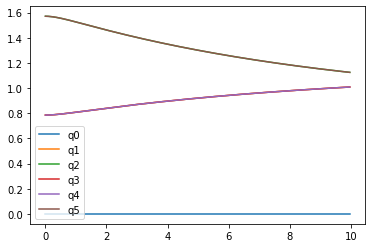

In [79]:
#This block of code calculates and plots a variety of data from the previous simulation
plt.figure()
artists = plt.plot(t,states[:,:6])
plt.legend(artists,['q0','q1','q2', 'q3', 'q4', 'q5'])

A graph of the energy shows the energy high when the motor is contracting the spring and slowly decreasing as the spring is released. 

2021-03-31 09:04:09,745 - pynamics.output - INFO - calculating outputs
2021-03-31 09:04:09,943 - pynamics.output - INFO - done calculating outputs


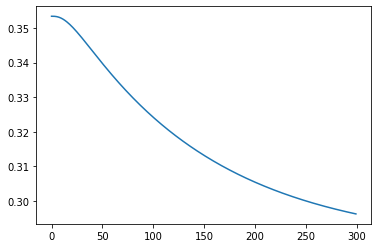

In [80]:
#This block of code calculates amd plots the energy of system
KE = system.get_KE()
PE = system.getPEGravity(pNA) - system.getPESprings()
energy_output = Output([KE-PE],system)
energy_output.calc(states)
energy_output.plot_time()

2021-03-31 09:04:10,258 - pynamics.output - INFO - calculating outputs
2021-03-31 09:04:10,348 - pynamics.output - INFO - done calculating outputs


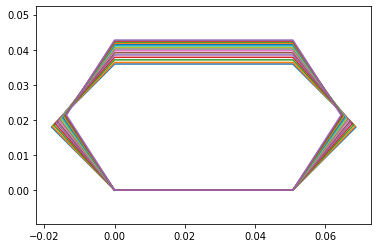

In [81]:
#This block of code calculates and plots the motion of the system
points = [pNA,pAB,pBC,pCD,pDE,pEF,pNA]
points_output = PointsOutput(points,system)
y = points_output.calc(states)
points_output.plot_time(20)

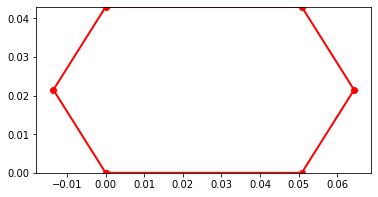

In [82]:
#This block of code produces a figure of the animations end position using matplotlib
points_output.animate(fps = fps,movie_name = 'render.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')

An animation of the sarrus link shows the motor contracting the spring and then slowly releasing it. The sarrus link starts contrcated and touches the outer walls. As the motor releases the spring, the sarrus link will extend vertically.

In [83]:
#This block of code animates the figure above
from matplotlib import animation, rc
from IPython.display import HTML
HTML(points_output.anim.to_html5_video())